<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-JunYear/blob/main/week%204/%5B4%EC%A3%BC%EC%B0%A8%5D_%EA%B8%B0%EB%B3%B8_%EA%B3%BC%EC%A0%9C_HuggingFace%EB%A1%9C_%EB%89%B4%EC%8A%A4_%EA%B8%B0%EC%82%AC_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HuggingFace로 뉴스 기사 분류하기

이번 과제에서는 이전 주차 과제에서 활용했던 fancyzhx/ag_news 문제를 HuggingFace로 구현하시면 됩니다. 다음 요구사항만 지키시면 됩니다.

- [ ]  `test` split은 학습에 활용되면 안됩니다.
- [ ]  `trainer.train()`에 대한 log가 남아있어야 합니다.
- [ ]  최종 모델의 `test` split에 대한 정확도가 print되어야 하며, 90%를 넘기셔야 합니다.
- [ ]  다음 예시에 대한 예측 결과를 출력하셔야 합니다.

```
UK charges 8 in terror plot linked to alert in US LONDON, AUGUST 17: Britain charged eight terror suspects on Tuesday with conspiracy to commit murder and said one had plans that could be used in striking US buildings that were the focus of security scares this month.
```

이외에는 validation data 유무, 모델 architecture, hyper-parameter 등은 위의 조건만 만족한다는 가정 하에서 마음대로 수정하셔도 됩니다.

In [1]:
!pip install transformers datasets evaluate accelerate scikit-learn

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00


In [2]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## Dataset 준비

그 다음 감정 분석을 위해 사용할 imdb dataset을 `load_dataset` 함수로 다운로드 받습니다.

In [3]:
ag_news = load_dataset("ag_news")
ag_news

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

`load_dataset`은 HuggingFace의 `datasets` library의 함수로, HuggingFace의 hub에서 dataset을 다운로드 받을 수 있도록 만든 함수입니다.
출력 결과를 보시면 `imdb`는 `train`, `test`, 그리고 `unsupervised` data로 구성되어있습니다.
이 중에서 우리는 `train`과 `test`를 활용합니다.

`train` data를 한 번 살펴보겠습니다.

In [4]:
ag_news['train'][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

`train`과 `test`의 각 data는 `text`와 `label`로 구성되어있습니다.
각각은 영화리뷰와 해당 영화리뷰의 긍정/부정 여부를 의미합니다.
이는 이전 주차들에서 사용한 imdb dataset과 동일합니다.

이번에는 tokenizer를 불러와서 미리 text들을 tokenize합니다.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def preprocess_function(data):
    return tokenizer(data["text"])  # truncation = True 제거

ag_news_tokenized = ag_news.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Tokenizer를 실행할 때 넘겨주었던 `truncation` 옵션은 주어진 text가 일정 길이 이상이면 잘라내라는 의미입니다.
만약 특정 길이 값이 같이 주어지지 않는다면 `bert-base-cased`를 학습할 때 사용한 text의 최대 길이를 기준으로 값을 결정합니다.

In [6]:
ag_news_tokenized['train'][0].keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

마지막 출력 결과를 보면, `text`와 `label` 이외에 `input_ids`가 생기신 것을 확인하실 수 있습니다.
이는 우리가 `AutoTokenizer.from_pretrained`로 불러온 tokenizer로 text를 token들로 나누고 정수 index로 변환한 결과입니다.

이번에는 `train` data를 쪼개 training data와 validation data를 만들어보겠습니다.

In [7]:
ag_news_split = ag_news_tokenized['train'].train_test_split(test_size=0.2)
ag_news_train, ag_news_val = ag_news_split['train'], ag_news_split['test']
ag_news_test = ag_news_tokenized['test']

HuggingFace `datasets`로 불러온 dataset은 `train_test_split`으로 쉽게 쪼갤 수 있습니다.

다음은 각 split의 크기입니다.

In [8]:
len(ag_news_train), len(ag_news_val), len(ag_news_test)

(96000, 24000, 7600)

In [9]:
# ag_news 데이터셋 라벨 갯수 확인
label_names = ag_news['train'].features['label'].names

for idx, label in enumerate(label_names):
  print(f"{idx}: {label}")

0: World
1: Sports
2: Business
3: Sci/Tech


In [10]:
num_ag_news = 4

## Model 구현

이번에는 text 분류를 수행할 Transformer를 구현합니다.
이전에는 Transformer의 구성 요소들을 직접 구현하여 합쳤습니다.
이번에는 HuggingFace의 BERT를 활용하여 인자만 넘겨주는 식으로 구현해보겠습니다:

In [11]:
from transformers import BertConfig

config = BertConfig()

config.hidden_size = 128  # BERT layer의 기본 hidden dimension
config.intermediate_size = 128  # FFN layer의 중간 hidden dimension
config.num_hidden_layers = 4  # BERT layer의 개수
config.num_attention_heads = 8  # Multi-head attention에서 사용하는 head 개수
config.num_labels = num_ag_news  # 마지막에 예측해야 하는 분류 문제의 class 개수

model = AutoModelForSequenceClassification.from_config(config)

BERT는 이전에 배운 Transformer의 architecture를 그대로 사용합니다.
그래서 BERT의 옵션들만 수정하면 vanilla Transformer를 쉽게 구현할 수 있습니다.

Transformer 구현 이외에 분류 문제에 맞춰 첫 번째 token을 linear classifier를 거치는 등의 과정은 `AutoModelForSequenceClassification`이 구현해줍니다.
즉, 우리가 `config`로 넘겨주는 BERT의 마지막에 linear classifier를 달아주는 역할을 합니다.

## 학습 코드

다음은 위에서 구현한 Transformer를 imdb로 학습하는 코드를 구현합니다.
먼저 다음과 같이 학습 인자들을 정의합니다.

In [12]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='hf_transformer',  # 모델, log 등을 저장할 directory
    num_train_epochs=30,  # epoch 수
    per_device_train_batch_size=16,  # training data의 batch size
    per_device_eval_batch_size=16,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-5,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
)

각각의 부분들은 이전 주차에서 배웠던 내용들을 설정하는 것에 불과하다는 것을 알 수 있습니다.
요약하면 다음과 같습니다:
- `epochs`: training data를 몇 번 반복할 것인지 결정합니다.
- `batch_size`: training data를 얼마나 잘게 잘라서 학습할 것인지 결정합니다.
- `learning_rate`: optimizer의 learning rate를 얼마로 할 것인지 결정합니다.
위의 부분들 이외에도 사소한 구현 요소들도 지정할 수 있습니다.

다음은 loss 이외의 평가 함수들을 구현하는 방법입니다.

In [13]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

`evaluate` 또한 HuggingFace의 library로 다양한 평가 함수들을 제공하고 있습니다.
이번 실습의 경우, 감정 분석 문제는 분류 문제이기 때문에 정확도를 계산할 수 있습니다.
위와 같이 예측 결과(`pred`)와 실제 label(`labels`)가 주어졌을 때 정확도를 계산하는 것은 `evaluate`의 accuracy 함수로 구현할 수 있습니다.

마지막으로 위의 요소들을 종합하여 학습할 수 있는 `Trainer`를 구현합니다.

In [14]:
from transformers import EarlyStoppingCallback


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ag_news_train,
    eval_dataset=ag_news_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]
    ## 만약 validation loss가 점점 안좋아지면 훈련을 빨리 멈추도록 함
)

모델, training 인자, training과 validation data, 부가적인 평가 함수, 그리고 tokenizer를 넘겨주면 끝입니다.
별개로 early stopping과 같은 기능도 주석 친 부분과 같이 `callbacks`로 구현할 수 있으니 참고해주시길 바랍니다.

위와 같이 만든 `Trainer`는 다음과 같이 학습을 할 수 있습니다.

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.096800,0.770641,0.680667
2,0.565100,0.442976,0.845958
3,0.361200,0.314019,0.898833
4,0.283300,0.294152,0.906500
5,0.251500,0.284888,0.913417
6,0.231200,0.288741,0.915375


TrainOutput(global_step=36000, training_loss=0.4648576287163628, metrics={'train_runtime': 674.2115, 'train_samples_per_second': 4271.656, 'train_steps_per_second': 266.979, 'total_flos': 153297307399680.0, 'train_loss': 0.4648576287163628, 'epoch': 6.0})

보시다시피 training loss는 잘 떨어지는 반면, validation loss는 중간부터 쭉 올라가는 것을 볼 수 있습니다.
Overfitting이 일어났다고 볼 수 있습니다.

위와 같이 학습이 끝난 후 validation loss가 가장 낮은 모델을 가지고 test data의 성능을 평가하는 것은 다음과 같이 구현할 수 있습니다.

In [16]:
trainer.evaluate(ag_news_test)

{'eval_loss': 0.30575254559516907,
 'eval_accuracy': 0.9092105263157895,
 'eval_runtime': 3.3122,
 'eval_samples_per_second': 2294.556,
 'eval_steps_per_second': 143.41,
 'epoch': 6.0}

이전에 학습 인자에서 `load_best_model_at_end=True`를 넘겨줬기 때문에 `trainer`는 학습이 끝난 후, 기본적으로 validation loss가 가장 좋은 모델을 가지고 `evaluate`를 진행합니다.
실제로 결과를 보면 `eval_loss`가 가장 낮은 validation loss와 유사한 것을 볼 수 있습니다.

평가할 때 사용한 모델은 다음과 같이 저장할 수 있습니다.

In [18]:
trainer.save_model()

그리고 저장한 모델을 가지고 다른 예시들을 예측하는 것은 다음과 같이 구현할 수 있습니다.

In [19]:
from transformers import pipeline


classifier = pipeline("sentiment-analysis", model="./hf_transformer/", device='cuda')
#print(classifier("The movie was so disgusting..."))
#print(classifier("The movie was so amazing!!"))
print(classifier("UK charges 8 in terror plot linked to alert in US LONDON, AUGUST 17: Britain charged eight terror suspects on Tuesday with conspiracy to commit murder and said one had plans that could be used in striking US buildings that were the focus of security scares this month."))

[{'label': 'LABEL_0', 'score': 0.9909610152244568}]


---

# Train Log


## Train 01
- Epoch 2->3 중 Loss 값이 커져 훈련 중 callback

```python
config.hidden_size = 128  # prev: 64
config.intermediate_size = 128  # prev: 64
config.num_hidden_layers = 4  # prev: 2
config.num_attention_heads = 8  # prev: 4
config.num_labels = num_ag_news  
```

```
Epoch	Training Loss	Validation Loss	Accuracy
1	0.401100	0.277521	0.906250
2	0.197400	0.259061	0.914250
3	0.134900	0.281562	0.914417
```

```
 [60/60 00:01]
{'eval_loss': 0.26055049896240234,
 'eval_accuracy': 0.9119736842105263,
 'eval_runtime': 2.0087,
 'eval_samples_per_second': 3783.632,
 'eval_steps_per_second': 29.871,
 'epoch': 3.0}
```

```
[{'label': 'LABEL_0', 'score': 0.6947908997535706}]
[{'label': 'LABEL_3', 'score': 0.48084840178489685}]
```

## Train 02
- batch_size를 조정하여도 별반 차이가 없음

```python
per_device_train_batch_size=64,  # prev: 128
per_device_eval_batch_size=64,  # prev: 128
```
```
Epoch	Training Loss	Validation Loss	Accuracy
1	0.165500	0.305183	0.904708
2	0.124000	0.341546	0.893792
```

## Train 03
- 모델의 크기를 늘렸는데, 실행 시간도 꽤 소요되었음에도
되려 정확도가 떨어짐
  - 이전 학습 결과들의 영향으로 예측되며, 추후의 학습부터는 런타임 해제 후 실행

```python
config.hidden_size = 256  # prev: 128
config.intermediate_size = 256  # prev: 128
config.num_hidden_layers = 8  # prev: 4
config.num_attention_heads = 16  # prev: 8
config.num_labels = num_ag_news

per_device_train_batch_size=16,  # prev: 64
per_device_eval_batch_size=16,  # prev: 64
```

```
Epoch	Training Loss	Validation Loss	Accuracy
1	1.390600	1.386715	0.249250
2	1.387400	1.386773	0.246958
```

```
{'eval_loss': 1.3868590593338013,
 'eval_accuracy': 0.25,
 'eval_runtime': 4.6658,
 'eval_samples_per_second': 1628.865,
 'eval_steps_per_second': 101.804,
 'epoch': 2.0}
```

## Train 04

```python
config.hidden_size = 128  # prev: 256
config.intermediate_size = 128  # prev: 256
config.num_hidden_layers = 4  # prev: 8
config.num_attention_heads = 8  # prev: 16

learning_rate=1e-5,  # prev: 1e-3
```

```
Epoch	Training Loss	Validation Loss	Accuracy
1	1.096800	0.770641	0.680667
2	0.565100	0.442976	0.845958
3	0.361200	0.314019	0.898833
4	0.283300	0.294152	0.906500
5	0.251500	0.284888	0.913417
6	0.231200	0.288741	0.915375
```

```
{'eval_loss': 0.30575254559516907,
 'eval_accuracy': 0.9092105263157895,
 'eval_runtime': 3.3122,
 'eval_samples_per_second': 2294.556,
 'eval_steps_per_second': 143.41,
 'epoch': 6.0}
```
```
[{'label': 'LABEL_0', 'score': 0.9909610152244568}]
```

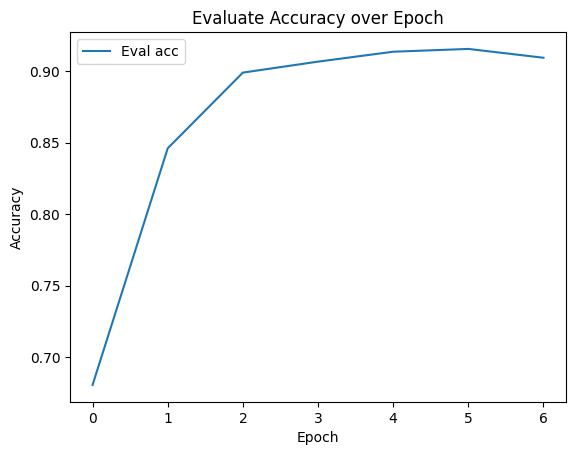

In [24]:
import matplotlib.pyplot as plt

def plot_acc(trainer):
  eval_acc = []
  log = trainer.state.log_history

  for entry in log:
    if 'eval_accuracy' in entry:
      eval_acc.append(entry['eval_accuracy'])

  plt.plot(eval_acc, label='Eval acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Evaluate Accuracy over Epoch')
  plt.show()

plot_acc(trainer)